# Análisis de sentimientos con NLP
**Antonio Coy García**

## Importación de librerías

In [94]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
!ls "/content/drive/My Drive/Colab Notebooks/NLP/TRABAJO NLP"

 sem_eval_test_blank_es.csv   sem_eval_train_es.csv  'TRABAJO NLP.ipynb'


## Lectura de datos

Importamos el dataset set desde drive:

In [97]:
#import dataset from data.csv file
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/TRABAJO NLP/sem_eval_train_es.csv')
df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3561 non-null   object
 1   Tweet         3561 non-null   object
 2   anger         3561 non-null   bool  
 3   anticipation  3561 non-null   bool  
 4   disgust       3561 non-null   bool  
 5   fear          3561 non-null   bool  
 6   joy           3561 non-null   bool  
 7   love          3561 non-null   bool  
 8   optimism      3561 non-null   bool  
 9   pessimism     3561 non-null   bool  
 10  sadness       3561 non-null   bool  
 11  surprise      3561 non-null   bool  
 12  trust         3561 non-null   bool  
dtypes: bool(11), object(2)
memory usage: 94.0+ KB


In [99]:
df_stats = df.drop(['ID', 'Tweet'], axis=1)
counts = []
categories = list(df_stats.columns.values)
for i in categories:
    counts.append((i, df_stats[i].sum()))
df_stats = pd.DataFrame(counts, columns=['Emoción', 'Número de tweets'])
df_stats

,Emoción,Número de tweets
0,anger,1155
1,anticipation,415
2,disgust,521
3,fear,373
4,joy,1087
5,love,261
6,optimism,378
7,pessimism,578
8,sadness,845
9,surprise,169


Text(0.5, 0, 'Emoción')

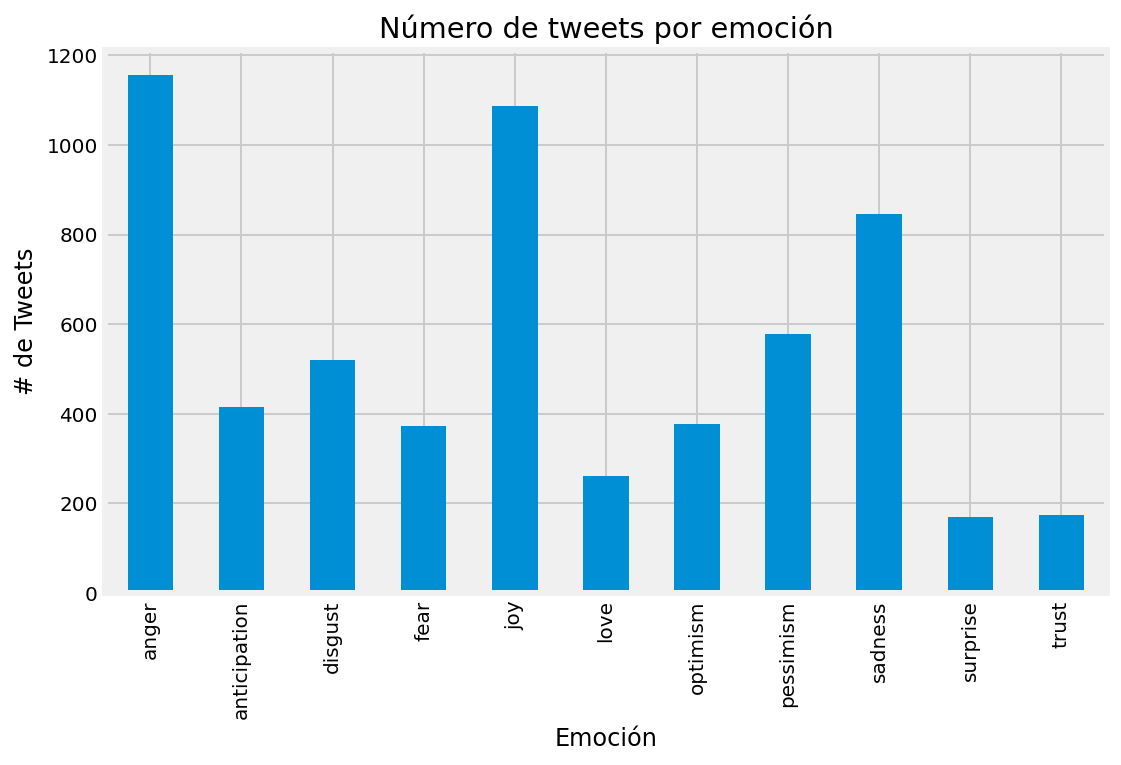

In [100]:
df_stats.plot(x='Emoción', y='Número de tweets', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Número de tweets por emoción")
plt.ylabel('# de Tweets', fontsize=12)
plt.xlabel('Emoción', fontsize=12)

Vemos como hay un claro desbalance en los datos, habiendo emociones como "surprise", "trust" o "love" infrarrepresentadas.

Vamos a crear una columna con la longitud de cada tuit.

In [101]:
df['pre_clean_len'] = df.Tweet.str.len()

In [102]:
df.pre_clean_len.describe()

count    3561.000000
mean       77.048301
std        35.753085
min         9.000000
25%        47.000000
50%        73.000000
75%       106.000000
max       140.000000
Name: pre_clean_len, dtype: float64

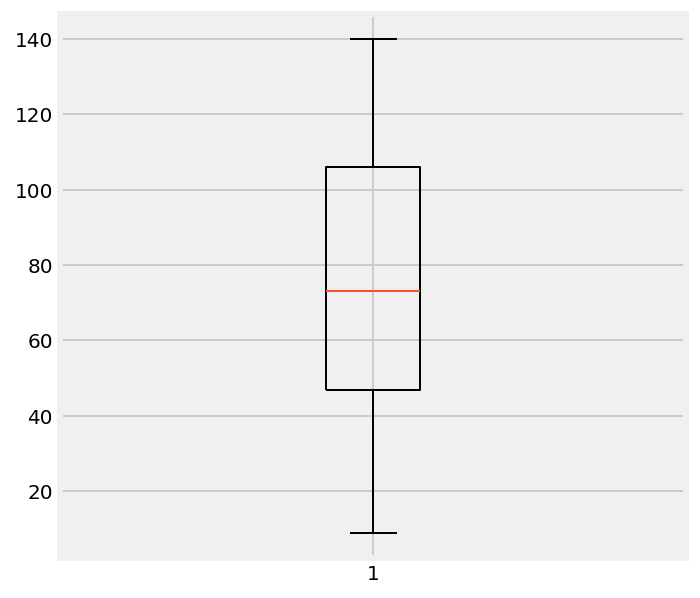

In [103]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

## Limpieza de texto
Tal como hemos visto en clase, hacemos un pre-procesado del texto. Para ello nos deshacemos de:  
- Las menciones y las URL del texto porque no aportan valor para el análisis de sentimientos.
- Los signos de hastag #.
- Los signos de puntuación y palabras menores de 3 caracteres.
- Todos los símbolos de puntuación del texto (que forman parte de un token).
- Lematizamos el texto y lo guardamos en otra columna.

In [104]:
!python -m spacy download es_core_news_md

2022-09-15 18:42:45.577080: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 180 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [105]:
import re, string, spacy
from spacy.lang.es.examples import sentences 
import es_core_news_md

nlp = spacy.load("es_core_news_md")

In [106]:
#lista de stop-words específicos de nuestro corpus (aproximación)
stop_words = ['unos', 'unas', 'algún', 'alguna', 'algunos', 'algunas', 'ese', 'eso', 'así']

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+', '', text) #elimina menciones y URL
    text = re.sub(r'https?://[\w_./]+', '', text) #elimina menciones y URL

    tokens = nlp(text) # Tokenización del texto
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens if not (tok in stop_words) and len(tok)>2]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

Probamos el funcionamiento de estas funciones sobre un tweet de ejemplo:

In [107]:
print('Original:\n',df.Tweet[1058])
print('\nLimpiado:\n',clean_text(df.Tweet[1058]))
print('\nLematizado:\n',clean_text(df.Tweet[1058], lemas=True))

Original:
 ¡Gran susto en la casa de #MOParaguay!😱 ¿Ña Susy sonámbula? ¿Actividad paranormal? Se convirtió en Lobo😐😐https://t.co/5mpN73aILF @MOParaguay

Limpiado:
 gran susto casa moparaguay susy sonámbula actividad paranormal convirtió lobo

Lematizado:
 gran susto casa moparaguay susy sonámbular actividad paranormal convertir lobo


Vamos a aplicar la limpieza a todos los tweets del DataFrame y creamos columna nueva con los limpios y los lemas

In [108]:
df["limpio"]=df['Tweet'].apply(clean_text)

In [109]:
#Quitamos tweets vacíos después de la limpieza
df=df[df.limpio!='']

In [110]:
df['lemas'] = df['Tweet'].apply(clean_text, lemas=True)

In [111]:
df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,pre_clean_len,limpio,lemas
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False,78,ajajjaa somos del clan twitteras perdidas even...,ajajjaa ser del clan twittera perdido evento i...
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False,64,mala suerte del gato fichame cara help pls,malo suerte del gato fichamar cara help pls
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False,100,tampoco agrado mucho especialmente por tratars...,tampoco agradar mucho especialmente por tratar...
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,132,para llevar los bebes lugar otro debemos canta...,para llevar beb uno lugar otro deber cantarl c...
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False,139,encanta terrible hipocresia doble moral que ti...,encantar terrible hipocresia doble moral que t...


Vamos a comparar las palabras contadas sin y con limpieza

In [112]:
#Contamos el nº de palabras por tweet
df['words'] = [len(t.split(' ')) for t in df.limpio]

In [113]:
df.describe()

,pre_clean_len,words
count,3557.000000,3557.000000
mean,77.105988,8.858308
std,35.731348,4.621153
min,9.000000,1.000000
25%,47.000000,5.000000
50%,73.000000,8.000000
75%,106.000000,12.000000
max,140.000000,22.000000


Como vemos, con la limpieza se reduce muchísimo el número de palabras a tratar.

## Split en train y test
En primer lugar, separamos en conjunto de entrenamiento y test. Escogemos el texto lematizado para entrenar.

In [114]:
from sklearn.model_selection import train_test_split

X = df['lemas']
Y = df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]


# Split data into training and test sets
# Asignamos un 70% a training y un 30% a test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=0)

In [115]:
X_train.head(5)

2014    que genial persona que llevar minuto hablar ha...
206                                vdd quien saber porqué
1245    dar miedo encontrar alguien con quien encariñi...
3474              cumplir uno festivo ser nada cool amigo
1286    anoche soñar que monstruo del festival del ter...
Name: lemas, dtype: object

In [116]:
y_train.head(5)

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
2014,False,False,False,False,True,False,True,False,False,False,True
206,False,False,False,False,False,False,False,False,False,True,False
1245,False,False,False,True,False,False,False,True,True,False,False
3474,True,False,True,False,False,False,False,False,True,False,False
1286,False,False,False,True,False,False,False,False,False,False,False


### Extracción de características BoW
Vamos a vectorizar los conjuntos de entrenamiento y de test mediante la librería scikit-learn.

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
# aprendemos el modelo CountVectorizer sobre el conjunto de train
vect = CountVectorizer()

X_train_vectorized = vect.fit_transform(X_train)
X_train_vectorized
X_test_vectorized = vect.transform(X_test)
X_test_vectorized.shape

(1068, 5447)

Vemos el número de términos distintos que tiene el diccionario:

In [118]:
len(vect.get_feature_names_out())

5447

In [119]:
np.random.choice(vect.get_feature_names_out(), 5, replace=False)

array(['fijarte', 'trueno', 'pizjuán', 'extraño', 'los'], dtype=object)

In [120]:
X_train_vectorized.toarray().shape

(2489, 5447)

## Modelo, entrenamiento, predicción y métricas
Resolvemos el problema haciendo uso del modelo Naive Bayes. Para ello, crearemos un modelo para cada sentimiento y haremos predicciones con cada uno.

### Introducción de datos de test_blank
Antes de nada, metemos también los datos de test_blank para la evaluación de la tarea para poder predecirlos junto con los demás.

In [146]:
#import dataset from data.csv file
df_blank = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/TRABAJO NLP/sem_eval_test_blank_es.csv')
df_blank.head()

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contr...
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había ll...
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondi...
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años ..."
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de un...


In [147]:
df_blank["limpio"]=df_blank['Tweet'].apply(clean_text)

In [148]:
df_blank['lemas'] = df_blank['Tweet'].apply(clean_text, lemas=True)

In [149]:
X_blank= df_blank['lemas']

In [150]:
X_blank = vect.transform(X_blank)

X_blank contiene los tuits sobre los que haremos las predicciones.

### Modelo

Usaremos el modelo Naive Bayes para las predicciones, debido a su sencillez y a su extendido uso en problemas de clasificación con texto (muy usado por ejemplo en la detección de SPAM).

In [151]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

list_label = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

modelNB = MultinomialNB()
prediccion = []
prediccion_blank = []
auc_score = {}
for label in list_label:
    model = MultinomialNB()
    model.fit(X_train_vectorized, y_train[label])
    auc_score[label] = roc_auc_score(y_test[label], model.predict_proba(X_test_vectorized)[:,1])
    prediccion.append(model.predict(X_test_vectorized)) # Predicciones del conjunto original para evaluar el modelo
    prediccion_blank.append(model.predict(X_blank)) # Predicciones del test_blank

pd.DataFrame(auc_score, index=['AUC score'])

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
AUC score,0.752748,0.561128,0.633102,0.667208,0.762614,0.638835,0.567288,0.573355,0.721123,0.505226,0.527122


Vemos algunas características de los datos de test obtenidos y más métricas en las que los evaluamos

In [129]:
y_test.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
992,False,False,False,False,False,True,False,False,True,False,False
464,True,False,False,False,False,False,False,False,False,False,False
961,False,False,False,False,True,False,False,False,False,False,False
196,False,False,True,False,False,False,False,True,False,False,False
828,False,False,False,False,False,False,False,False,False,False,False


In [130]:
y_test.shape

(1068, 11)

In [131]:
prediccion = pd.DataFrame(prediccion).transpose()
prediccion = prediccion.set_axis(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'], axis=1, inplace=False)

In [132]:
prediccion.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


### Matriz de Confusión y Clasification Report

Matriz de Confusión de cada emoción.

In [133]:
from sklearn.metrics import confusion_matrix

for i in range(11):
  print(list_label[i])
  cm=confusion_matrix(y_test.iloc[:,i], prediccion.iloc[:,i])
  print(pd.DataFrame(cm, index=('F_true','T_true'), columns=('F_pred','T_pred')))
#filas: True, columnas: Prediction


anger
        F_pred  T_pred
F_true     673      52
T_true     211     132
anticipation
        F_pred  T_pred
F_true     950       2
T_true     115       1
disgust
        F_pred  T_pred
F_true     902       3
T_true     157       6
fear
        F_pred  T_pred
F_true     962       0
T_true      98       8
joy
        F_pred  T_pred
F_true     697      40
T_true     210     121
love
        F_pred  T_pred
F_true     985       3
T_true      80       0
optimism
        F_pred  T_pred
F_true     962       2
T_true     101       3
pessimism
        F_pred  T_pred
F_true     880       8
T_true     170      10
sadness
        F_pred  T_pred
F_true     782      19
T_true     208      59
surprise
        F_pred  T_pred
F_true    1018       0
T_true      50       0
trust
        F_pred  T_pred
F_true    1023       1
T_true      44       0


Vemos el classification report de cada emoción por individual.

In [134]:
for i in range(11):
  print(list_label[i])
  print(classification_report(y_test.iloc[:,i], prediccion.iloc[:,i]))

anger
              precision    recall  f1-score   support

       False       0.76      0.93      0.84       725
        True       0.72      0.38      0.50       343

    accuracy                           0.75      1068
   macro avg       0.74      0.66      0.67      1068
weighted avg       0.75      0.75      0.73      1068

anticipation
              precision    recall  f1-score   support

       False       0.89      1.00      0.94       952
        True       0.33      0.01      0.02       116

    accuracy                           0.89      1068
   macro avg       0.61      0.50      0.48      1068
weighted avg       0.83      0.89      0.84      1068

disgust
              precision    recall  f1-score   support

       False       0.85      1.00      0.92       905
        True       0.67      0.04      0.07       163

    accuracy                           0.85      1068
   macro avg       0.76      0.52      0.49      1068
weighted avg       0.82      0.85      0.79    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ahora lo vemos de forma más generalizada.

In [135]:

recall = [None]*11
precision = [None]*11
score = [None]*11

for i in range(11):
  true = y_test.iloc[:,i]
  prediction = prediccion.iloc[:,i]

  from sklearn.metrics import f1_score, recall_score, precision_score

  recall[i] = recall_score(y_true=true, y_pred=prediction, average='weighted')
  precision[i] = precision_score(y_true=true, y_pred=prediction, average='weighted')
  score[i] = f1_score(y_true=true, y_pred=prediction, average='weighted')


df_metrics = pd.DataFrame(list(zip(recall,precision,score,list_label)),
               columns =["recall", "precision", "f-score", "emociones"])
df_metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,recall,precision,f-score,emociones
0,0.753745,0.747207,0.728764,anger
1,0.890449,0.831338,0.841505,anticipation
2,0.850187,0.823500,0.788993,disgust
3,0.908240,0.916723,0.871023,fear
4,0.765918,0.763225,0.737579,joy
5,0.922285,0.855603,0.887693,love
6,0.903558,0.875287,0.862116,optimism
7,0.833333,0.790476,0.772117,pessimism
8,0.787453,0.781527,0.740449,sadness
9,0.953184,0.908559,0.930336,surprise


## Inferencia en el conjunto ciego de Test
Finalmente, vamos a guardar las predicciones obtenidas en un csv para su evaluación.

In [152]:
np.shape(prediccion_blank)

(11, 679)

In [153]:
prediccion_blank = pd.DataFrame(prediccion_blank).transpose()
prediccion_blank = prediccion_blank.set_axis(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'], axis=1, inplace=False)

In [154]:
predicciones_blank = prediccion_blank.assign(ID=df_blank['ID'])

In [155]:
predicciones_blank.insert(0, 'ID', predicciones_blank.pop('ID'))

In [156]:
predicciones_blank.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-06697,True,False,False,False,False,False,False,False,False,False,False
1,2018-Es-05385,False,False,False,False,False,False,False,False,False,False,False
2,2018-Es-03777,False,False,False,False,False,False,False,False,False,False,False
3,2018-Es-02175,False,False,False,False,False,False,False,False,False,False,False
4,2018-Es-00726,False,False,False,False,False,False,False,False,False,False,False


Comprobamos que cumple las condiciones de estructura:

In [157]:
predicciones_blank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            679 non-null    object
 1   anger         679 non-null    bool  
 2   anticipation  679 non-null    bool  
 3   disgust       679 non-null    bool  
 4   fear          679 non-null    bool  
 5   joy           679 non-null    bool  
 6   love          679 non-null    bool  
 7   optimism      679 non-null    bool  
 8   pessimism     679 non-null    bool  
 9   sadness       679 non-null    bool  
 10  surprise      679 non-null    bool  
 11  trust         679 non-null    bool  
dtypes: bool(11), object(1)
memory usage: 12.7+ KB


Finalmente, exportamos el csv:

In [161]:
predicciones_blank.to_csv('soluciones_antonio_coy_garcia.csv')
!cp soluciones_antonio_coy_garcia.csv '/content/drive/My Drive/Colab Notebooks/NLP/TRABAJO NLP/'